# importing acl-anthology bib file & creating csv

In [2]:
import requests
import gzip
import shutil
import os
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/nell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# download anthology file
url = "https://aclanthology.org/anthology+abstracts.bib.gz"
r = requests.get(url)
open('anthology+abstracts.bib.gz', 'wb').write(r.content)

# open and unpack gz
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
os.remove("anthology+abstracts.bib.gz")

In [2]:
# watch out: computes very long
# if you've run this + the following cell once, there should e a csv in your directory
# in that case you can uncomment the cell after the next one and read straight from the csv
import bibtexparser

# parse bib file, output: list of dicts
with open('anthology+abstracts.bib') as bibtex_file:   
    bib_database = bibtexparser.bparser.BibTexParser(common_strings=True).parse_file(bibtex_file)


In [ ]:
import pandas as pd
import sre_yield

# define keywords & words to exclude

keywords = ['asymmetry', 'bias', 'fair', 'imbalanced data', 'personal attribute', 'protected attribute', 'protected categor', 'social group signals', 'stereotype']
    
# somehow french articles tended to guide their way into the bib file
excludes = ['abuse' 'hate', 'hate speech', ' offensive', ' les ', ' des ', ' en ']
df = pd.DataFrame()

for paper in bib_database.entries:
    if 'abstract' in paper.keys():
        if any(keyword in paper['abstract'] for keyword in keywords):
            if not any(exclude in paper['abstract'] for exclude in excludes):
                temp_row = {}

                # select only select papers from 2016 on
                if 'year' in paper.keys() and int(paper['year']) >= 2016:

                    for cat in paper.keys():
                        temp_row[cat] = paper[cat]

                    df = df.append(temp_row, ignore_index=True)
        
df.to_csv('bias_paper.csv')

In [3]:
# uncomment if csv is already in directory (and save time parsing the bib file)
import pandas as pd
df = pd.read_csv('bias_paper_reduced.csv')
print(len(df))

494


In [5]:
df.head()

,Unnamed: 0,ENTRYTYPE,ID,abstract,address,author,booktitle,doi,month,pages,publisher,title,url,year,journal,volume,number,language,isbn
0,0,inproceedings,chuang-etal-2021-mitigating,Automatic detection of toxic language plays an...,Online,"Chuang, Yung-Sung and\nGao, Mingye and\nLuo,...",Proceedings of the 5th Workshop on Online Abus...,10.18653/v1/2021.woah-1.12,aug,114--120,Association for Computational Linguistics,Mitigating Biases in Toxic Language Detection ...,https://aclanthology.org/2021.woah-1.12,2021,NaN,NaN,NaN,NaN,NaN
1,2,inproceedings,lent-sogaard-2021-common,Large-scale language models such as ELMo and B...,Online,"Lent, Heather and\nS{\o}gaard, Anders",Proceedings of the Seventh Workshop on Noisy U...,10.18653/v1/2021.wnut-1.14,nov,114--119,Association for Computational Linguistics,Common Sense Bias in Semantic Role Labeling,https://aclanthology.org/2021.wnut-1.14,2021,NaN,NaN,NaN,NaN,NaN
2,3,inproceedings,murayama-etal-2021-mitigation,Fake news causes significant damage to society...,Online,"Murayama, Taichi and\nWakamiya, Shoko and\nA...",Proceedings of the Seventh Workshop on Noisy U...,10.18653/v1/2021.wnut-1.21,nov,182--188,Association for Computational Linguistics,Mitigation of Diachronic Bias in Fake News Det...,https://aclanthology.org/2021.wnut-1.21,2021,NaN,NaN,NaN,NaN,NaN
3,4,inproceedings,ghosh-etal-2021-detecting,Online social media platforms increasingly rel...,Online,"Ghosh, Sayan and\nBaker, Dylan and\nJurgens,...",Proceedings of the Seventh Workshop on Noisy U...,10.18653/v1/2021.wnut-1.35,nov,313--328,Association for Computational Linguistics,Detecting Cross-Geographic Biases in Toxicity ...,https://aclanthology.org/2021.wnut-1.35,2021,NaN,NaN,NaN,NaN,NaN
4,5,inproceedings,bertsch-bethard-2021-detection,"On Wikipedia, an online crowdsourced encyclope...",Online,"Bertsch, Amanda and\nBethard, Steven",Proceedings of the Seventh Workshop on Noisy U...,10.18653/v1/2021.wnut-1.36,nov,329--333,Association for Computational Linguistics,Detection of Puffery on the {E}nglish {W}ikipedia,https://aclanthology.org/2021.wnut-1.36,2021,NaN,NaN,NaN,NaN,NaN


# tf-idf & clustering

In [6]:
# inspiration from: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

In [7]:
import re
import nltk
from nltk.corpus import stopwords

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    
    # remove links, special characters, numbers, stopwords, whitespaces
    # also remove words that are actually filters
    stopwords_list = stopwords.words("english")
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stopwords_list]
        text = " ".join(tokens)
    
    text = text.lower().strip()
    
    return text

In [8]:
# create cleaned column
df['cleaned_w_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True)) \
                + df['title'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df['cleaned_wo_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)
X = vectorizer.fit_transform(df['cleaned_w_title'])
Y = vectorizer.fit_transform(df['cleaned_wo_title'])

In [10]:
print(f'entries: {len(df.index)}')

entries: 494


In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# elbow-test

In [10]:
import matplotlib.pyplot as plt

def elbow_test(data, max_k=16, max_iter=500):
    # perform elbow test
    cost =[]
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i, max_iter=max_iter)
        kmeans.fit(data)

        # calculates squared error
        # for the clustered points
        cost.append(kmeans.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, max_k), cost, color ='g', linewidth ='3')
    plt.title("Elbow test for clustering with Title as input")
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot

elbow_test(X, max_k=21)

KeyboardInterrupt: 

# PCA & KMeans

In [12]:
def make_pca_vecs(data, n_clusters=5):
# vary here the number of clusters
    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(data)
    clusters = kmeans.labels_
    # initialize PCA with 2 components
    pca = PCA(n_components=2, random_state=42)
    # pass our X to the pca and store the reduced vectors into pca_vecs
    pca_vecs = pca.fit_transform(data.toarray())
    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    return clusters, clusters, x0, x1

In [15]:
# assign clusters and pca vectors to our dataframe 
clusters_df, df['cluster'], df['x0'], df['x1'] = make_pca_vecs(X, n_clusters=4)

In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 100

In [18]:
def get_top_keywords(this_df, data, clusters, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(data.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(df, X, clusters_df, 10)



Cluster 1
representations,problem,knowledge,fairness,english,multiple,evaluation,linguistic,system,translation

Cluster 2
knowledge,analysis,used,several,media,words,representation,corpus,embedding,embeddings

Cluster 3
multiple,existing,sentences,generation,information,attributes,media,better,approach,systems

Cluster 4
corpora,analysis,representations,debiasing,groups,study,demonstrate,several,new,may


In [19]:
# map clusters to appropriate labels 
cluster_map = {0: "cluster 01", 
               1: "cluster 02", 
               2: "cluster 03", 
               3: "cluster 04", 
               4: "cluster 05", 
               5: "cluster 06", 
              }
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

# visualizing outputs

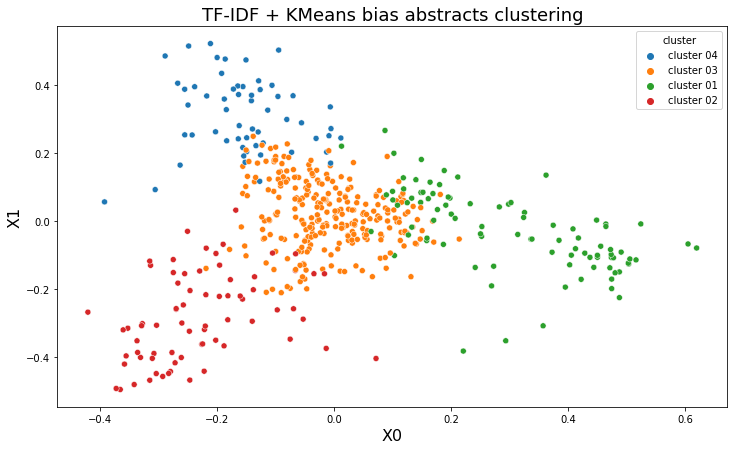

In [20]:
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

def make_kmeans_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF + KMeans bias abstracts clustering", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='cluster')
    plt.show()
    
make_kmeans_plot(df)

# stats & plots

## ngram analysis

In [21]:
from nltk.util import ngrams
from collections import Counter

def count_ngrams(num, keyword_list, pos):
    ngrams = []
    for idx, row in df.iterrows():
        tokens = nltk.word_tokenize(row['cleaned_w_title'])
        ngrams += nltk.ngrams(tokens, num)

    frequence = Counter(ngrams)
    bias_ngrams = []
    for entry, value in frequence.most_common():
        if entry[pos] in keyword_list:
            bias_ngrams.append((entry, value))
            
    return bias_ngrams


print('POSITION 0')
print('BIGRAMS')
print(count_ngrams(2, ['bias', 'biases'], 0)[:20])
print()
print('TRIGRAMS')
print(count_ngrams(3, ['bias', 'biases'], 0)[:40])
print('BIGRAMS')
print()
print('POSITION 1')
print(count_ngrams(2, ['bias', 'biases'], 1)[:20])
print()
print('TRIGRAMS')
print(count_ngrams(3, ['bias', 'biases'], 1)[:40])
print()
print('POSITION 2')
print('TRIGRAMS')
print(count_ngrams(3, ['bias', 'biases'], 2)[:40])

POSITION 0
BIGRAMS
[(('bias', 'word'), 34), (('bias', 'detection'), 20), (('bias', 'news'), 18), (('biases', 'present'), 17), (('bias', 'mitigation'), 17), (('biases', 'word'), 15), (('bias', 'nlp'), 15), (('bias', 'machine'), 13), (('bias', 'within'), 12), (('biases', 'language'), 11), (('bias', 'evaluation'), 11), (('biases', 'encoded'), 11), (('bias', 'natural'), 10), (('bias', 'text'), 10), (('bias', 'models'), 9), (('bias', 'data'), 9), (('bias', 'training'), 9), (('bias', 'present'), 8), (('bias', 'propose'), 8), (('biases', 'models'), 8)]

TRIGRAMS
[(('bias', 'word', 'embeddings'), 20), (('biases', 'word', 'embeddings'), 13), (('bias', 'natural', 'language'), 10), (('bias', 'news', 'articles'), 9), (('bias', 'machine', 'translation'), 8), (('bias', 'coreference', 'resolution'), 5), (('bias', 'mitigation', 'techniques'), 5), (('bias', 'training', 'data'), 5), (('biases', 'present', 'training'), 4), (('bias', 'nlp', 'systems'), 4), (('biases', 'training', 'data'), 4), (('biases', 

## type of bias plot

In [22]:
# hand crafted bias list (feel free to change)
bias_list = [' age', 'dataset bias', 'diachronic', ' entity', ' ethnic', 'exposure', ' gender', 
             ' media', ' political', ' race', ' religion', ' social', 'societal']

# ONE HOT ENCODING
def one_hot(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df[i] = this_df['cleaned_w_title'].str.contains(i)
        
def add_not_spec_col(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df.loc[(this_df[i] == True), 'not_specified'] = False
        
    this_df.loc[(this_df['not_specified'].isnull()), 'not_specified'] = True
        
one_hot(df)
add_not_spec_col(df)

In [23]:
def count_biases(this_df, bias_list=bias_list):
    counts = []
    for i in bias_list:
        counts.append(this_df[i].value_counts())
        
    counts.append(this_df['not_specified'].value_counts())
    
    return counts

 age             9
dataset bias     0
diachronic       2
 entity          2
 ethnic          7
exposure         0
 gender         51
 media          31
 political       7
 race           13
 religion        3
societal         2
Name: True, dtype: int64


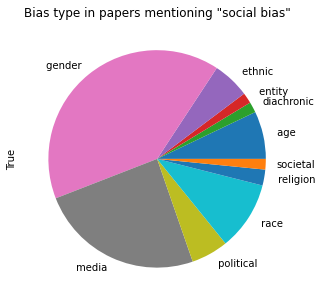

In [42]:
def count_social_biases(this_df, bias_list=bias_list):
    counts = []
    temp_df = pd.DataFrame()
    for i in bias_list:
        if i == ' social':
            continue
        temp_df[i] = pd.crosstab(this_df[i],this_df[' social']).loc[True]
                
    temp_df.loc[True].plot.pie(figsize=(5, 5));
    plt.title('Bias type in papers mentioning "social bias"')
        
    return temp_df.loc[True]

print(count_social_biases(df, bias_list=bias_list))

               False  True 
 age             461     33
dataset bias     478     16
diachronic       488      6
 entity          480     14
 ethnic          481     13
exposure         476     18
 gender          291    203
 media           444     50
 political       474     20
 race            462     32
 religion        484     10
 social          400     94
societal         475     19
not_specified    323    171


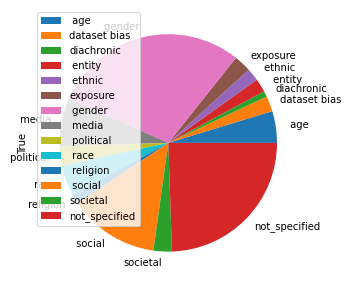

In [25]:
def plot_counts(this_df):
    df_counts = pd.concat(count_biases(this_df), axis=1).transpose()
    print(df_counts)
    df_counts.plot.pie(y=True, figsize=(5, 5));
    
plot_counts(df)

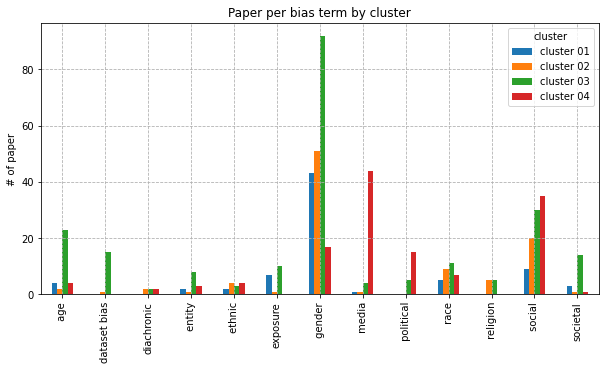

In [26]:
# cluster per bias
def clust_per_bias_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['cluster']).loc[True]

    temp_df.transpose().plot.bar();
    plt.title('Paper per bias term by cluster')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')

clust_per_bias_plot(df)

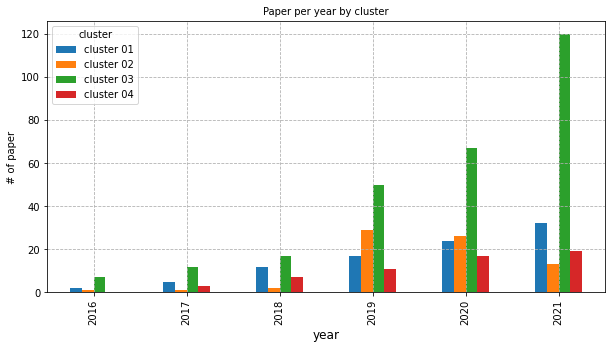

In [27]:
# year per cluster
def year_per_clust_plot(this_df):
    pd.crosstab(this_df['year'],this_df['cluster']).plot.bar();
    plt.title('Paper per year by cluster', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_clust_plot(df)

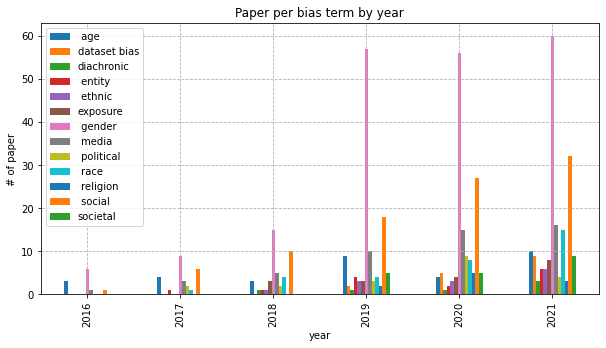

In [28]:
# bias per year
def bias_per_year_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['year']).loc[True]

    temp_df.plot.bar();
    plt.title('Paper per bias term by year')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
bias_per_year_plot(df)

## type of research plots

In [35]:
verb_list = {'analysis': ['analy', 'exploit', 'detect', 'investigat'], 
             'debiasing': ['mitigat', 'debias', 'reduc']} # list of verbs to get insights about the type of research


In [44]:
# ONE HOT ENCODING
def one_hot_verb(this_df, verb_list=verb_list):
    for key in verb_list.keys():
        for i in verb_list[key]:
            this_df[key] = this_df['cleaned_w_title'].str.contains(i)
            
        this_df.loc[(this_df[key] == True), 'no_verb'] = False   
    this_df.loc[(this_df['no_verb'].isnull()), 'no_verb'] = True

one_hot_verb(df)

[False    418
True      76
Name: analysis, dtype: int64, False    299
True     195
Name: debiasing, dtype: int64, debiasing
False    43
True     33
Name: True, dtype: int64, True     250
False    244
Name: no_verb, dtype: int64]


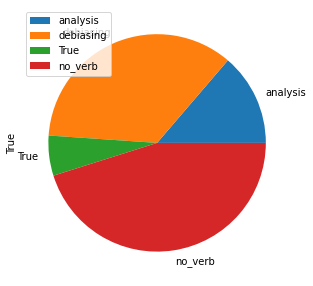

In [45]:
def plot_verb_count(this_df):
    counts = []
    for key in verb_list.keys():
        counts.append(this_df[key].value_counts())
    counts.append(pd.crosstab(this_df['analysis'],this_df['debiasing']).loc[True])
    counts.append(this_df['no_verb'].value_counts())
        
    print(counts)
        
    df_counts = pd.concat(counts, axis=1).transpose()
    df_counts.plot.pie(y=True, figsize=(5, 5));
    
plot_verb_count(df)

## type of task plots

In [54]:
task_list = ['speech recognition', 'generation', 'translation', 'coreference resolution', 'role labeling',
             'pos-tagging', 'embeddings', 'captioning', 'question answering', 'named entity recognition']


In [55]:
# ONE HOT ENCODING
def one_hot_task(this_df, task_list=task_list):
    for i in task_list:
        this_df[i] = this_df['cleaned_w_title'].str.contains(i)
            
        this_df.loc[(this_df[i] == True), 'no_task'] = False   
    this_df.loc[(this_df['no_task'].isnull()), 'no_task'] = True

one_hot_task(df)

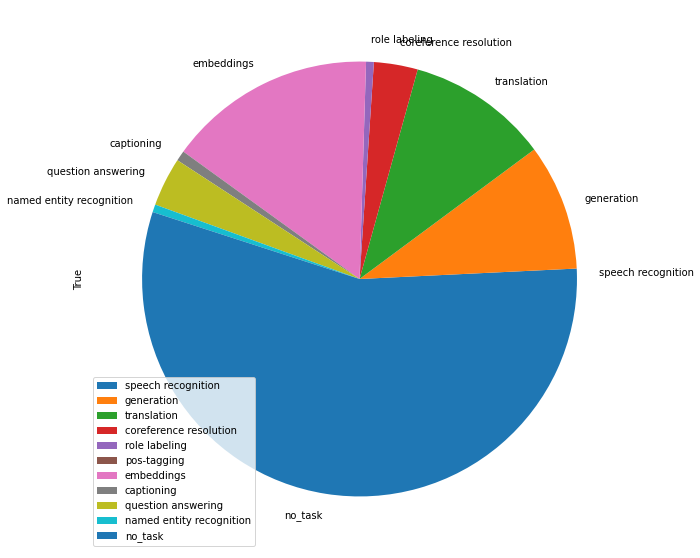

In [56]:
def plot_task_count(this_df):
    counts = []
    for i in task_list:
        counts.append(this_df[i].value_counts())
        
    counts.append(this_df['no_task'].value_counts())
        
    #print(counts)
        
    df_counts = pd.concat(counts, axis=1).transpose()
    df_counts.plot.pie(y=True, figsize=(10, 10));
    
plot_task_count(df)

In [86]:
### LDA with inspiration from here: https://medium.com/analytics-vidhya/topic-modelling-using-lda-aa11ec9bec13#:~:text=Topic%20modelling%20in%20natural%20language%20processing%20is%20a%20technique%20which,important%20to%20categories%20the%20documents.
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(this_df, col, range_min=1, range_max=3, mindf=0.01, maxdf=0.5):
    
    """Returns the count vectorized dataframe based on the arguments
    
    param df(dataframe): dataframe containing the values
    param  d(str): the column name, under which the documents are present
    param range_min(int): smallest n of n-gram wanted
    param range_max(int): largest n of n-gram wanted
    param mindf(int): threshold for common words
    param maxdf(int): threshold for rare words
    
    return cv(CountVectorizer): the count vectorizer
           cv_df(dataframe): dataframe containing the bag of words"""
    
    vectorizer = CountVectorizer(ngram_range=(range_min, range_max), min_df=mindf, max_df=maxdf)
    Z = vectorizer.fit_transform(this_df[col])
    new_df = pd.DataFrame(Z.toarray(), columns = vectorizer.get_feature_names())
    
    return Z, new_df, vectorizer

Z_df, _, cv_df = get_bow(df, 'cleaned_w_title')


In [89]:
# Use LDA to look for 6 topics
from sklearn.decomposition import LatentDirichletAllocation

def make_lda(this_df, Z, vectorizer, n_topics=6, n_words=10):
    model_lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    model_lda.fit(Z)

    feature_names = vectorizer.get_feature_names()

    topic_list = []
    for topic_idx, topic in enumerate(model_lda.components_):
        top_n = [feature_names[i]
                  for i in topic.argsort()
                   [-n_words:]][::-1]

        top_features = ' '.join(top_n)

        topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

        print(f"Topic {topic_idx}:\n{top_features}")
        print('\n')

    topic_result = model_lda.transform(Z)
    this_df['topic']  = topic_result.argmax(axis=1)
    
make_lda(df, Z_df, cv_df, n_topics=4)

Topic 0:
gender social models human analysis biases differences text demographic show


Topic 1:
gender gender bias word biases embeddings data models word embeddings translation nlp


Topic 2:
models model data training biases datasets performance show dataset learning


Topic 3:
news word biases embeddings different text media articles embedding model




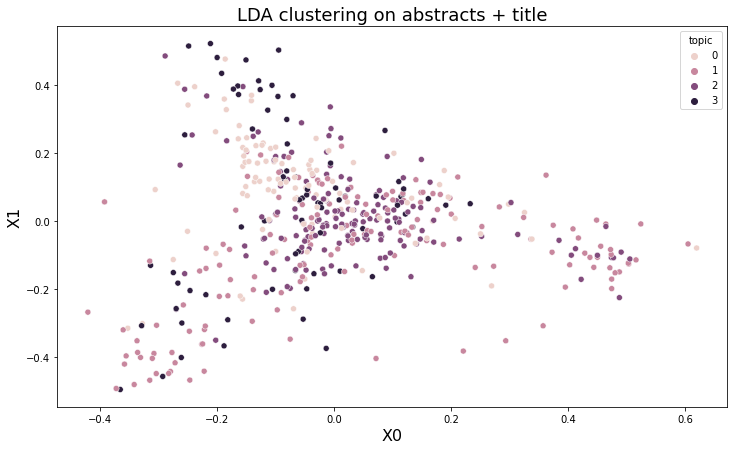

In [90]:
def make_lda_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    plt.title("LDA clustering on abstracts + title", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='topic')
    plt.show()
    
make_lda_plot(df)

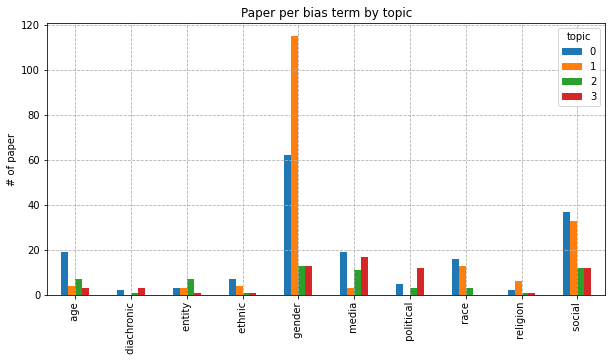

In [91]:
# topic per bias
def topic_per_bias_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['topic']).loc[True]

    temp_df.transpose().plot.bar();
    plt.title('Paper per bias term by topic')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')

topic_per_bias_plot(df)

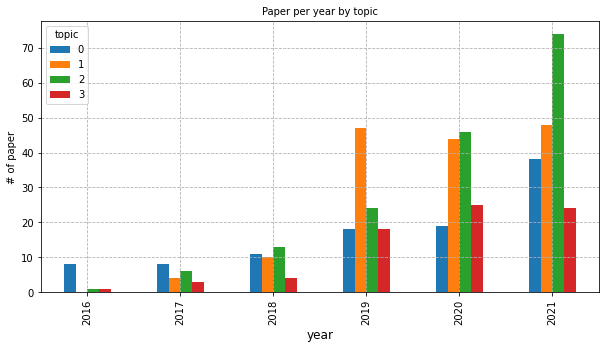

In [92]:
# year per topic
def year_per_topic_plot(this_df):
    pd.crosstab(this_df['year'],this_df['topic']).plot.bar();
    plt.title('Paper per year by topic', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_topic_plot(df)

In [93]:
# TODO
# how do cluster correspond to topic
df_ws = df[df['booktitle'].str.contains('Workshop', na=False)]
df_co = df[df['booktitle'].str.contains('Conference', na=False)]

def main(this_df, data, n_cluster=6, max_words=20, bias_list=bias_list, run_stats=True):
    # length of dataframe
    print(f'entries: {len(this_df.index)}')
    
    # create cluster & pca components & print keywords for cluster
    cluster, this_df['cluster'], this_df['x0'], this_df['x1'] = make_pca_vecs(data, n_cluster)
    get_top_keywords(this_df, data, cluster, max_words)
    this_df['cluster'] = this_df['cluster'].map(cluster_map)
    
    # create kmeans plot
    make_kmeans_plot(this_df)
    #elbow_test(data)
    
    # do one hot encoding & create stats plots
    if run_stats:
        one_hot(this_df)
        plot_counts(this_df)
        clust_per_bias_plot(this_df, bias_list)
        bias_per_year_plot(this_df, bias_list)
    
    year_per_clust_plot(this_df)
    
    # create lda vectorizer & perform LDA
    Z_df, _, cv_df = get_bow(this_df, 'cleaned_w_title')
    make_lda(this_df, Z_df, cv_df, n_topics=n_cluster)
    make_lda_plot(df)
    
    # stats of LDA
    if run_stats:
        topic_per_bias_plot(df)
        
    year_per_topic_plot(df)

In [94]:
pd.options.mode.chained_assignment = None  # default='warn'
# create vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)

entries: 160

Cluster 1
performance,semantic,women,related,several,large,research,representations,generation,methods,techniques,corpora,new,words,studies,recent,embedding,debiasing,time,embeddings

Cluster 2
human,one,specific,two,tasks,studies,often,groups,find,methods,many,classification,datasets,analyze,approach,learning,may,fairness,training,research

Cluster 3
approach,embeddings,method,neural,proposed,representations,performance,sentence,pronouns,level,english,system,trained,languages,machine,pronoun,set,translation,resolution,bert

Cluster 4
words,analyze,information,datasets,methods,women,related,investigate,experiments,users,understanding,across,specific,use,large,differences,detection,articles,media,news

Cluster 5
differences,representation,network,languages,information,question,methods,related,users,system,groups,across,new,human,two,use,neural,evaluation,generation,linguistic


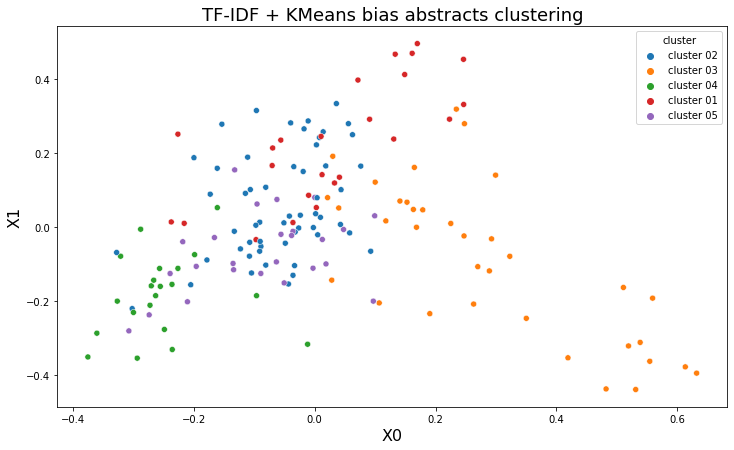

               False  True 
 age             149     11
 diachronic      154      6
 entity          156      4
 ethnic          157      3
 gender           76     84
 media           134     26
 political       151      9
 race            152      8
 religion        157      3
 social          115     45
not_specified    115     45
Topic 0:
biases translation models machine analysis data machine translation word paper social


Topic 1:
news different media using social models differences based training text


Topic 2:
text model social generation studies training paper causal exposure bias exposure


Topic 3:
word gender bias embeddings word embeddings biases nlp data natural natural language research


Topic 4:
models bert task model based dataset resolution biases data pronoun




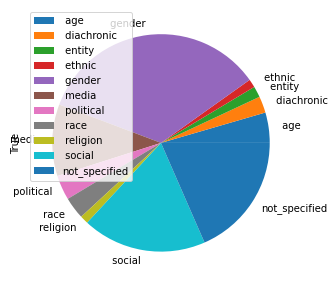

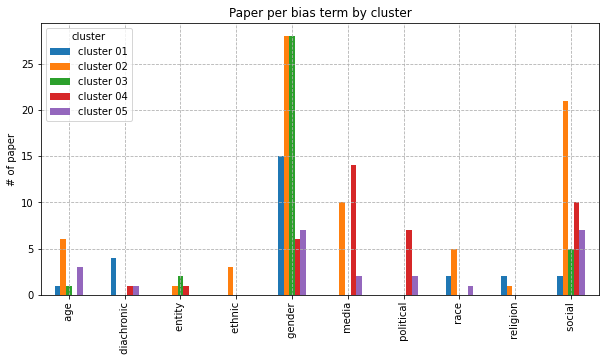

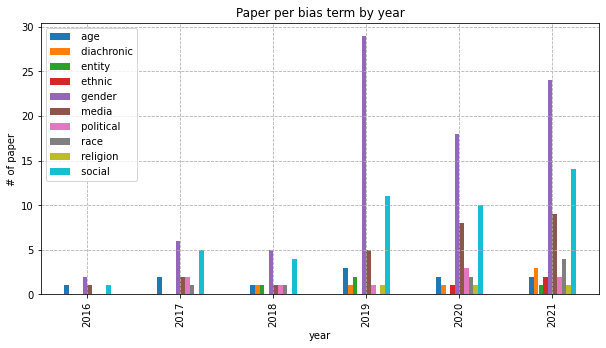

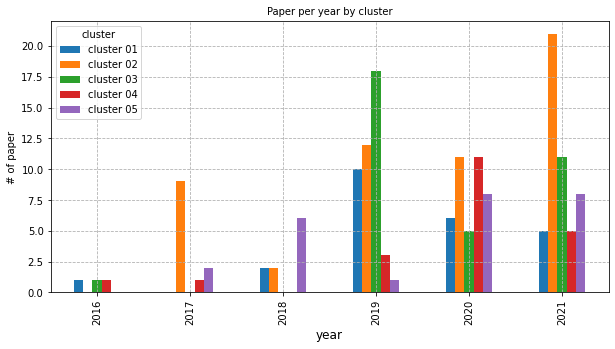

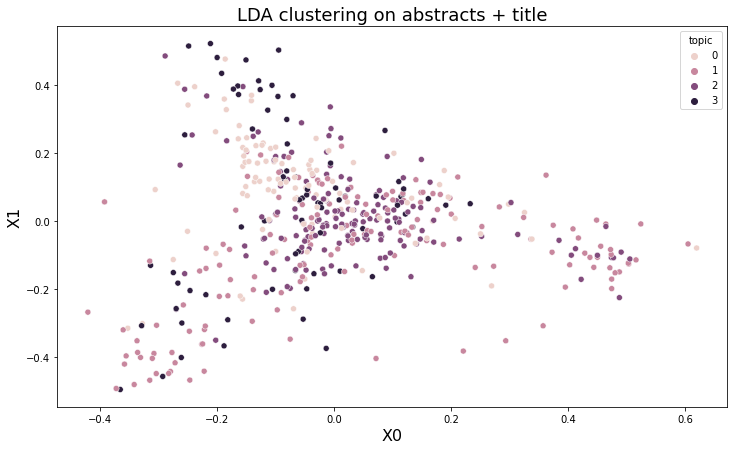

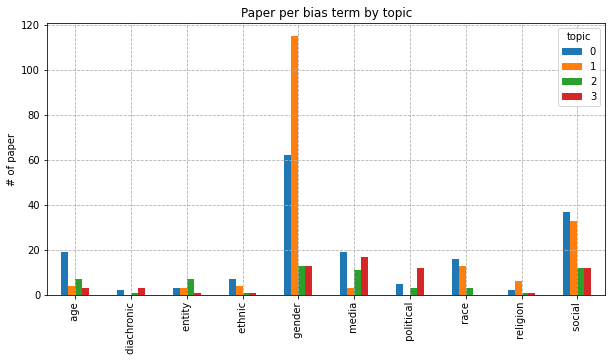

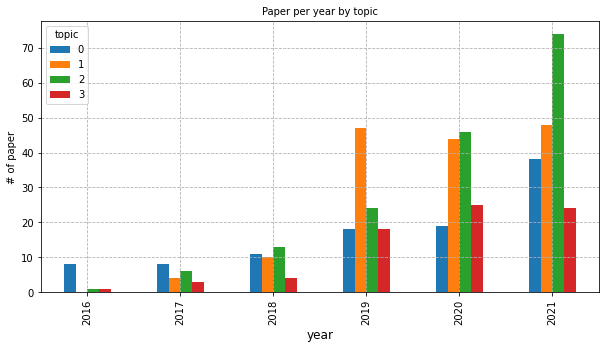

In [95]:
# ONLY LOOK AT WORKSHOP PAPERS
data1 = vectorizer.fit_transform(df_ws['cleaned_w_title'])
main(df_ws, data1, n_cluster=5)

entries: 241

Cluster 1
analysis,one,demonstrate,domain,techniques,generation,large,study,question,new,sentence,sentences,corpus,novel,introduce,first,detection,systems,media,news

Cluster 2
well,prediction,study,languages,investigate,sentence,often,fine,approaches,test,accuracy,level,inference,problem,english,evaluation,systems,mt,machine,translation

Cluster 3
better,demonstrate,pre,bert,fairness,detection,large,approach,debiasing,attributes,proposed,natural,set,inference,question,without,nlp,adversarial,existing,classification

Cluster 4
find,nlp,approach,biased,knowledge,pre,corpora,proposed,demonstrate,across,languages,non,social,words,stereotypes,representation,debiasing,embedding,representations,embeddings

Cluster 5
systems,first,approach,words,introduce,test,social,one,may,evaluation,english,state,biased,languages,analysis,corpus,across,new,linguistic,generation


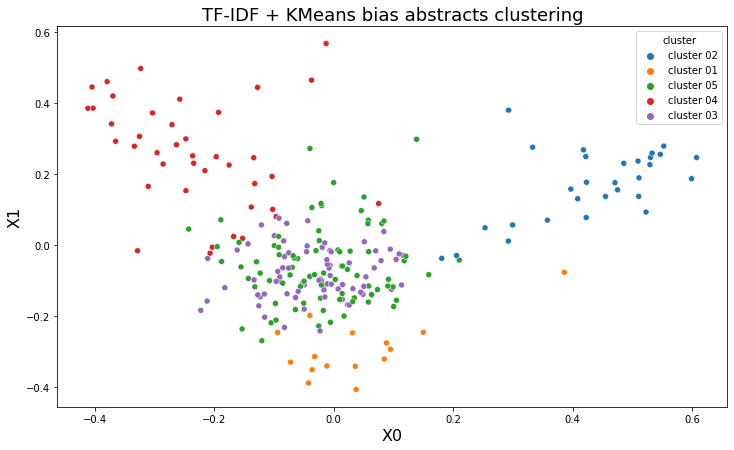

               False  True 
 age           221.0   20.0
 diachronic    241.0    NaN
 entity        236.0    5.0
 ethnic        234.0    7.0
 gender        153.0   88.0
 media         224.0   17.0
 political     232.0    9.0
 race          222.0   19.0
 religion      237.0    4.0
 social        203.0   38.0
not_specified  126.0  115.0


KeyError: True

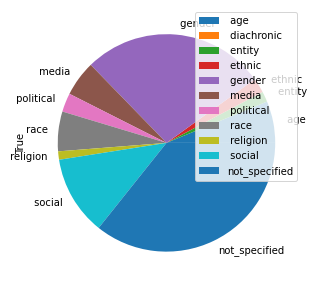

In [96]:
# ONLY LOOK AT CONFERENCE PAPERS
data2 = vectorizer.fit_transform(df_co['cleaned_w_title'])
main(df_co, data2, n_cluster=5)

In [ ]:
# ONLY LOOK AT PAPERS CONTAINING "SOCIAL"
df_social = df[df['abstract'].str.contains('social', na=False)]
data_social = vectorizer.fit_transform(df_social['cleaned_w_title'])
bias_list_social = [' age', ' race', ' gender', ' ethnic', ' religion']
main(df_social, data_social, n_cluster=5, bias_list=bias_list_social)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 3 CLUSTER
df_unspec = df[df['not_specified'] == True]
data_unspec = vectorizer.fit_transform(df_unspec['cleaned_w_title'])
main(df_unspec, data_unspec, n_cluster=3, run_stats = False)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 2 CLUSTER
main(df_unspec, data_unspec, n_cluster=2, run_stats = False)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 6 CLUSTER
main(df_unspec, data_unspec, n_cluster=6, run_stats = False)